# Imports

In [1]:
library(dplyr)
library(ggplot2)
library(caret)
library(caTools)
library(xgboost)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice

Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice



In [19]:
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

# Loading the data 

In [20]:
hr_train <- read.csv('hr_analytics/train_LZdllcl.csv')
str(hr_train)

'data.frame':	54808 obs. of  14 variables:
 $ employee_id         : int  65438 65141 7513 2542 48945 58896 20379 16290 73202 28911 ...
 $ department          : Factor w/ 9 levels "Analytics","Finance",..: 8 5 8 8 9 1 5 5 1 8 ...
 $ region              : Factor w/ 34 levels "region_1","region_10",..: 32 15 11 16 19 12 13 28 13 1 ...
 $ education           : Factor w/ 4 levels "","Bachelor's",..: 4 2 2 2 2 2 2 4 2 4 ...
 $ gender              : Factor w/ 2 levels "f","m": 1 2 2 2 2 2 1 2 2 2 ...
 $ recruitment_channel : Factor w/ 3 levels "other","referred",..: 3 1 3 1 1 3 1 3 1 3 ...
 $ no_of_trainings     : int  1 1 1 2 1 2 1 1 1 1 ...
 $ age                 : int  35 30 34 39 45 31 31 33 28 32 ...
 $ previous_year_rating: int  5 5 3 1 3 3 3 3 4 5 ...
 $ length_of_service   : int  8 4 7 10 2 7 5 6 5 5 ...
 $ KPIs_met..80.       : int  1 0 0 0 0 0 0 0 0 1 ...
 $ awards_won.         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ avg_training_score  : int  49 60 50 50 73 85 59 63 83 54 ...
 $ is_promo

# Removing the employee_id column and duplicate values

In [22]:
hr_train$employee_id <- NULL

In [23]:
hr_train <- distinct(hr_train)

# Changing the class names from 1 and 0 to "yes" and "no"

In [24]:
for (i in 1:nrow(hr_train)) {
    hr_train$is_promoted[i] = if(hr_train$is_promoted[i] == 1) "yes" else "no"
}

In [25]:
head(hr_train)

department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met..80.,awards_won.,avg_training_score,is_promoted
Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5,8,1,0,49,no
Operations,region_22,Bachelor's,m,other,1,30,5,4,0,0,60,no
Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3,7,0,0,50,no
Sales & Marketing,region_23,Bachelor's,m,other,2,39,1,10,0,0,50,no
Technology,region_26,Bachelor's,m,other,1,45,3,2,0,0,73,no
Analytics,region_2,Bachelor's,m,sourcing,2,31,3,7,0,0,85,no


# Replacing the null values with the modes of the attributes

In [26]:
print("ROWS WITH NULL VALUES:")
sapply(hr_train, function(x) sum(x=="" | is.na(x)))

[1] "ROWS WITH NULL VALUES:"


department               region            education 
                   0                    0                 2398 
              gender  recruitment_channel      no_of_trainings 
                   0                    0                    0 
                 age previous_year_rating    length_of_service 
                   0                 4062                    0 
       KPIs_met..80.          awards_won.   avg_training_score 
                   0                    0                    0 
         is_promoted 
                   0

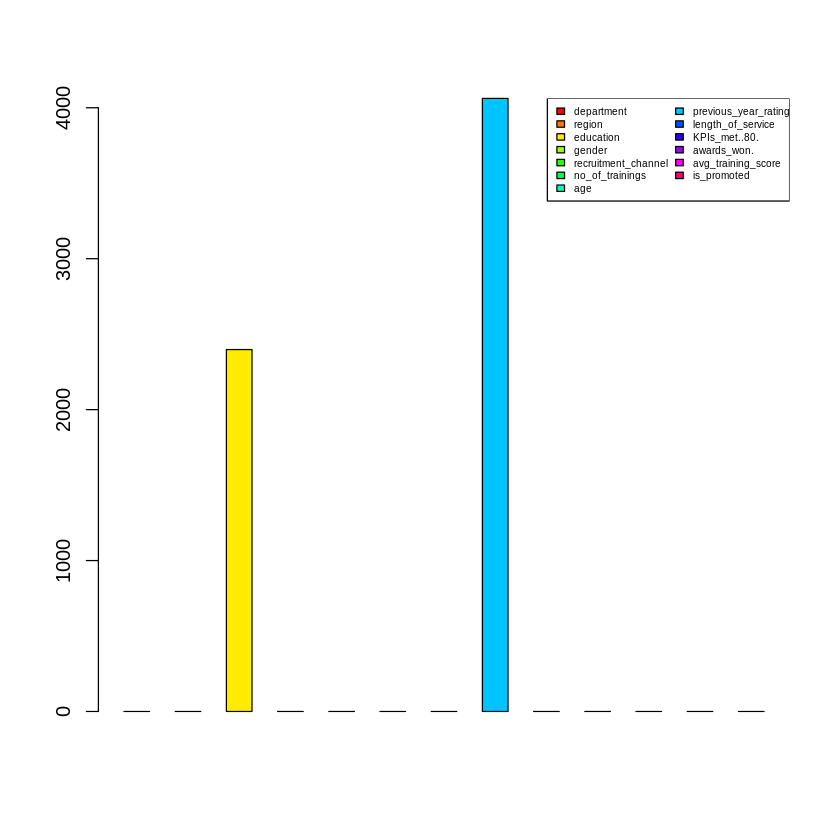

In [28]:
missing <- sapply(hr_train, function(x) sum(x=="" | is.na(x)))
missing <- (t(data.frame(missing)))
n <- names(data.frame(missing))
barplot(missing, beside = T,
        col = rainbow(length(missing)), xaxt='n')
                  
                  
legend("topright", 
       legend = n, 
       fill = rainbow(length(missing)), ncol = 2,
       cex = 0.5)

In [29]:
non_null <- na.omit(hr_train)

In [30]:
nrow(non_null)

[1] 50628

In [31]:
hr_train[hr_train$education == "" & hr_train$is_promoted == "no", grep("education", colnames(hr_train))] <- getmode(subset(hr_train, is_promoted == "no")$education) 
hr_train[hr_train$education == "" & hr_train$is_promoted == "yes", grep("education", colnames(hr_train))] <- getmode(subset(hr_train, is_promoted == "yes")$education)
hr_train[is.na(hr_train["previous_year_rating"]) & hr_train$is_promoted == "no", grep("previous_year_rating", colnames(hr_train))] <- getmode(subset(hr_train, is_promoted == "no")$previous_year_rating)
hr_train[is.na(hr_train["previous_year_rating"]) & hr_train$is_promoted == "yes", grep("previous_year_rating", colnames(hr_train))] <- getmode(subset(hr_train, is_promoted == "yes")$previous_year_rating)

In [32]:
nrow(hr_train)

[1] 54690

# Balancing the classes

Var1,Freq
no,0.91470104
yes,0.08529896



   no   yes 
50025  4665 

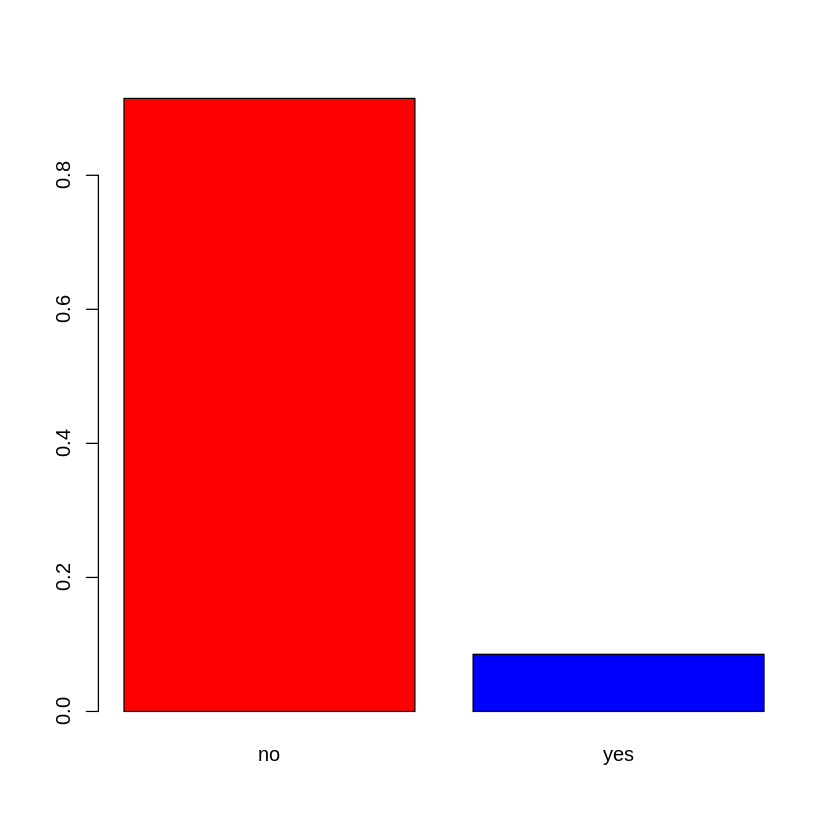

In [33]:
barplot(prop.table(table(hr_train$is_promoted)), col=c("red","blue"))
data.frame(prop.table(table(hr_train$is_promoted))) 
table(hr_train$is_promoted)

Var1,Freq
no,0.5
yes,0.5


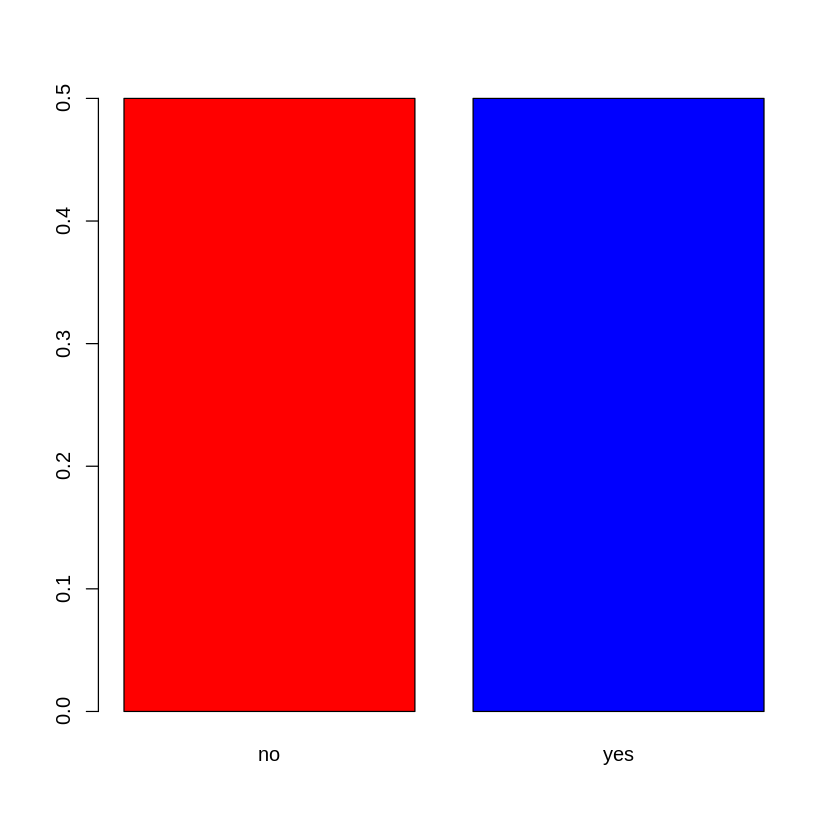

In [40]:
barplot(prop.table(table(min_train$is_promoted)), col=c("red","blue"))
data.frame(prop.table(table(min_train$is_promoted))) 

# Splitting the data into training and testing sets

In [39]:
set.seed(42)

temp1 <- subset(hr_train, is_promoted == "yes")
temp2 <- subset(hr_train, is_promoted == "no")

temp2 <- temp2[sample(nrow(temp1)),]
min_train <- rbind(temp1, temp2)

rows <- sample(nrow(min_train))
min_train <- min_train[rows,]

In [41]:
index = createDataPartition(min_train$is_promoted, p=4/5, list=FALSE)
train_data <- min_train[index,]
test_data <- min_train[-index,]

# Hyperparameters for training

In [42]:
params <- trainControl(method="cv",
                      number=5,
                      savePredictions=TRUE,
                      classProbs=TRUE)

# Training the Random Forest

In [43]:
random_forest <- train(as.factor(is_promoted)~.,
              data=train_data,
              method="rf",
              trControl=params)

In [44]:
random_forest

Random Forest 

7464 samples
  12 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 5972, 5972, 5972, 5970, 5970 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.7600484  0.5200968
  28    0.8161811  0.6323622
  54    0.8105528  0.6211057

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 28.

In [45]:
confusionMatrix(random_forest)

Cross-Validated (5 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   no  yes
       no  37.5  5.8
       yes 12.5 44.2
                            
 Accuracy (average) : 0.8162


rf variable importance

  only 20 most important variables shown (out of 54)

                            Overall
avg_training_score           832.70
KPIs_met..80.                533.48
previous_year_rating         381.64
length_of_service            313.44
age                          301.19
departmentSales & Marketing  186.40
awards_won.                  114.01
departmentOperations         102.15
departmentProcurement         67.42
no_of_trainings               67.28
recruitment_channelsourcing   60.31
genderm                       55.79
regionregion_2                41.94
departmentTechnology          39.70
departmentFinance             38.99
regionregion_22               38.76
regionregion_7                36.84
educationMaster's & above     31.27
departmentHR                  30.92
educationBachelor's           30.88

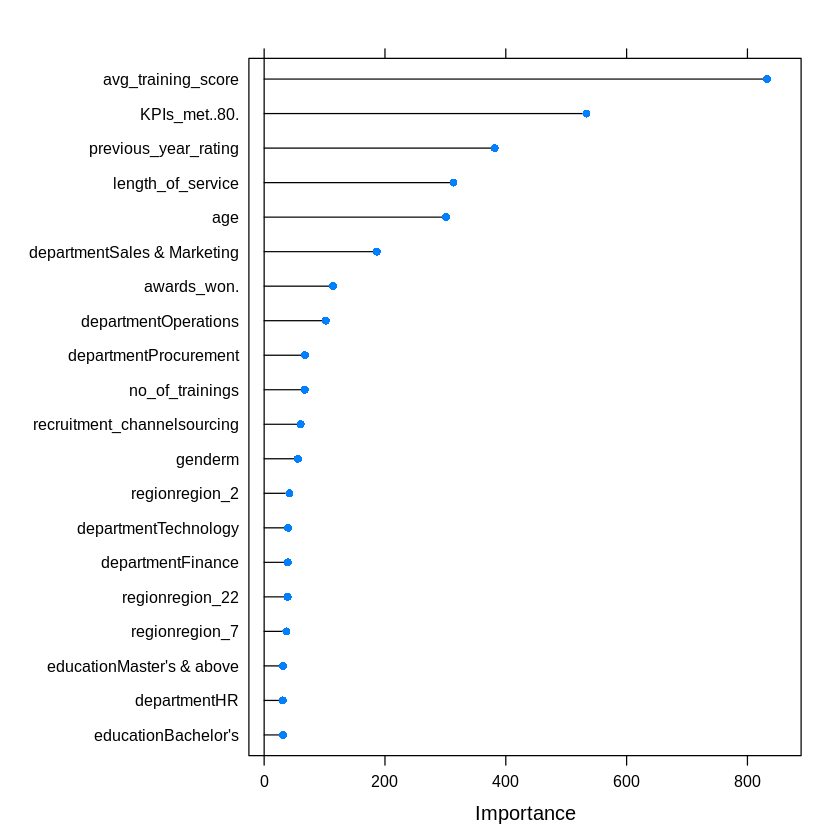

In [46]:
plot(varImp(random_forest, scale=FALSE), top=20)
varImp(random_forest, scale=FALSE)

In [47]:
rfpreds <- predict(random_forest, test_data)

In [48]:
confusionMatrix(table(rfpreds, test_data$is_promoted))

Confusion Matrix and Statistics

       
rfpreds  no yes
    no  719 122
    yes 214 811
                                          
               Accuracy : 0.8199          
                 95% CI : (0.8017, 0.8371)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6399          
                                          
 Mcnemar's Test P-Value : 6.889e-07       
                                          
            Sensitivity : 0.7706          
            Specificity : 0.8692          
         Pos Pred Value : 0.8549          
         Neg Pred Value : 0.7912          
             Prevalence : 0.5000          
         Detection Rate : 0.3853          
   Detection Prevalence : 0.4507          
      Balanced Accuracy : 0.8199          
                                          
       'Positive' Class : no              
                                          

# Training the XGBoost tree

In [50]:
xgbtree <- train(as.factor(is_promoted)~.,
              data=train_data,
              method="xgbTree",
              trControl=params)

In [51]:
xgbtree

eXtreme Gradient Boosting 

7464 samples
  12 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 5970, 5972, 5971, 5971, 5972 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  Accuracy   Kappa    
  0.3  1          0.6               0.50        50      0.7430301  0.4860646
  0.3  1          0.6               0.50       100      0.7569643  0.5139280
  0.3  1          0.6               0.50       150      0.7641990  0.5283971
  0.3  1          0.6               0.75        50      0.7400815  0.4801619
  0.3  1          0.6               0.75       100      0.7554887  0.5109784
  0.3  1          0.6               0.75       150      0.7619207  0.5238410
  0.3  1          0.6               1.00        50      0.7364661  0.4729291
  0.3  1          0.6               1.00       100      0.7537470  0.5074944
  0.3  1          0.6               1.00       150      0.7600433 

In [52]:
confusionMatrix(xgbtree)
xgbtree$pred

Cross-Validated (5 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   no  yes
       no  38.1  5.1
       yes 11.9 44.9
                            
 Accuracy (average) : 0.8301


pred,obs,rowIndex,no,yes,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,Resample
no,yes,11,0.81190646,0.1880935,0.3,1,0,0.6,1,0.5,150,Fold1
no,yes,12,0.54240084,0.4575992,0.3,1,0,0.6,1,0.5,150,Fold1
no,yes,18,0.61163652,0.3883635,0.3,1,0,0.6,1,0.5,150,Fold1
no,no,20,0.55684888,0.4431511,0.3,1,0,0.6,1,0.5,150,Fold1
no,no,26,0.92591250,0.0740875,0.3,1,0,0.6,1,0.5,150,Fold1
no,no,33,0.84007031,0.1599297,0.3,1,0,0.6,1,0.5,150,Fold1
no,no,45,0.86138523,0.1386148,0.3,1,0,0.6,1,0.5,150,Fold1
no,no,47,0.82855266,0.1714473,0.3,1,0,0.6,1,0.5,150,Fold1
no,no,52,0.83102465,0.1689754,0.3,1,0,0.6,1,0.5,150,Fold1
yes,yes,53,0.18751892,0.8124811,0.3,1,0,0.6,1,0.5,150,Fold1


In [53]:
xgbpreds <- predict(xgbtree, test_data)

In [54]:
confusionMatrix(table(xgbpreds, test_data$is_promoted))

Confusion Matrix and Statistics

        
xgbpreds  no yes
     no  731 108
     yes 202 825
                                          
               Accuracy : 0.8339          
                 95% CI : (0.8162, 0.8505)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6677          
                                          
 Mcnemar's Test P-Value : 1.277e-07       
                                          
            Sensitivity : 0.7835          
            Specificity : 0.8842          
         Pos Pred Value : 0.8713          
         Neg Pred Value : 0.8033          
             Prevalence : 0.5000          
         Detection Rate : 0.3917          
   Detection Prevalence : 0.4496          
      Balanced Accuracy : 0.8339          
                                          
       'Positive' Class : no              
                                          

xgbTree variable importance

  only 20 most important variables shown (out of 54)

                             Overall
avg_training_score          0.298036
KPIs_met..80.               0.239061
previous_year_rating        0.140940
departmentSales & Marketing 0.069869
length_of_service           0.048764
awards_won.                 0.034820
departmentProcurement       0.031456
departmentOperations        0.029417
age                         0.018234
departmentHR                0.011814
departmentFinance           0.011585
departmentTechnology        0.010275
no_of_trainings             0.007006
regionregion_22             0.006087
regionregion_4              0.003136
genderm                     0.002850
departmentR&D               0.002684
departmentLegal             0.002543
educationMaster's & above   0.002407
regionregion_2              0.002385

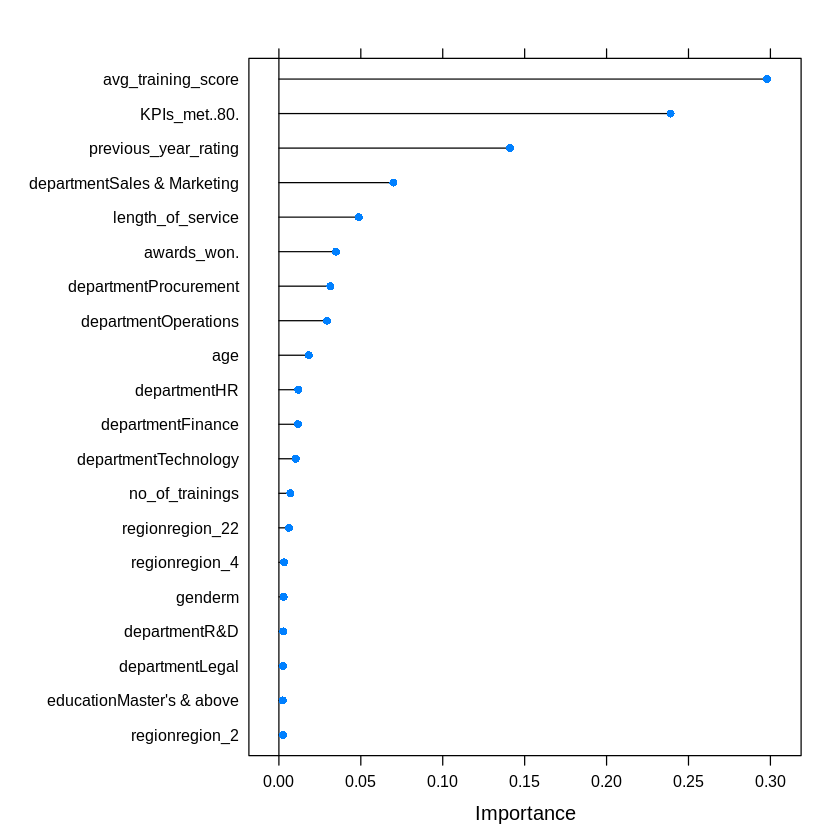

In [55]:
plot(varImp(xgbtree, scale=FALSE), top=20)
varImp(xgbtree, scale=FALSE)